<a href="https://colab.research.google.com/github/mrzResearchArena/ACP/blob/master/hybrid-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
ls

drive/  sample_data/


In [3]:
cd 'drive/My Drive/Colab-Notebooks'

/content/drive/My Drive/Colab-Notebooks


In [4]:
ls

0_FINAL_anti_peptide_model_AC240-tensorboard.ipynb
0_FINAL_anti_peptide_model_ACP740-tensorboard.ipynb
500-164.h5
544_encoded_sequences_740.npy
ACP164.npy
ACP240_labels.npy
acp240.txt
ACP-500-164.h5
ACP500.npy
ACP740_labels.npy
ACP-740-tensorboard.ipynb
acp740.txt
blosum-164.npy
blosum-240.npy
blosum-500.npy
blosum62-acp240.npy
blosum62-acp740.npy
blosum-740.npy
bpf-164.npy
bpf-240.npy
bpf-500.npy
bpf-740.npy
BPF_coded_ACP164_sequences.npy
BPF_coded_ACP240_sequences.npy
BPF_coded_ACP500_sequences.npy
BPF_coded_ACP740_sequences.npy
dataset-50000.csv
drive/
kmer_k_3_ACP240.npy
kmer_k_3_ACP740.npy
logs/
mACP-240.ipynb
mACP-740.ipynb
model-240b.png
model-240.png
model-50000.png
model-500-164.png
model-740.png
model.png
multichannel.png
physico_coded_ACP164_sequences.npy
physico_coded_ACP240_sequences.npy
physico_coded_ACP500_sequences.npy
physico_coded_ACP740_sequences.npy
Sarcasm_Headlines_Dataset_v2.json
X-50000.npy
Y-50000.npy


In [5]:
ls *.csv -1

dataset-50000.csv


In [6]:
# Deep Neural Networks:
import tensorflow as tf; print('We\'re working on TF-{}.'.format(tf.__version__))
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten, BatchNormalization,
                                     Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,
                                     LSTM, GRU, Embedding, Bidirectional, concatenate)
from tensorflow.keras.regularizers import (l1, l2, l1_l2)
from tensorflow.keras.optimizers import (RMSprop, Adam, SGD)
from tensorflow.keras.models import (Sequential, Model)

# Core:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Performance:
from sklearn.metrics import (confusion_matrix, classification_report, matthews_corrcoef, precision_score)

#Utilities:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical as labelEncoding   # Usages: Y = labelEncoding(Y, dtype=int)
from tensorflow.keras.utils import plot_model                        # Usages: plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, expand_nested=True)
from sklearn.model_selection import (StratifiedKFold, KFold, train_test_split)
#end-import

We're working on TF-2.2.0-rc2.


In [0]:
# X = np.load('X-50000.npy')
# Y = np.load('Y-50000.npy')

# print(X.shape)
# print(Y.shape)

def zero_one_encoding(Y):
    '''
    Argument: Class Label (Y)
    --> [1, 0, 2]
    Return: one hot encoding matrix (2D-array NumPy-array)
    --> array([[0, 1, 0],
               [1, 0, 0],
               [0, 0, 1]])
    '''
    N = len(Y)
    K = len(set(Y))
    index = np.zeros(shape=(N, K), dtype=int)
    for i, value in enumerate(Y):
        index[i, value] = 1
    return index

In [8]:
# Data Load
D = pd.read_csv('dataset-50000.csv')
D.head(5)

,Sequence,Class,Index_0_A,Index_1_A,Index_2_A,Index_3_A,Index_4_A,Index_5_A,Index_6_A,Index_7_A,Index_8_A,Index_9_A,Index_10_A,Index_11_A,Index_12_A,Index_13_A,Index_14_A,Index_15_A,Index_16_A,Index_17_A,Index_18_A,Index_19_A,Index_20_A,Index_21_A,Index_22_A,Index_0_C,Index_1_C,Index_2_C,Index_3_C,Index_4_C,Index_5_C,Index_6_C,Index_7_C,Index_8_C,Index_9_C,Index_10_C,Index_11_C,Index_12_C,Index_13_C,Index_14_C,...,Index_6_G,Index_7_G,Index_8_G,Index_9_G,Index_10_G,Index_11_G,Index_12_G,Index_13_G,Index_14_G,Index_15_G,Index_16_G,Index_17_G,Index_18_G,Index_19_G,Index_20_G,Index_21_G,Index_22_G,Index_0_T,Index_1_T,Index_2_T,Index_3_T,Index_4_T,Index_5_T,Index_6_T,Index_7_T,Index_8_T,Index_9_T,Index_10_T,Index_11_T,Index_12_T,Index_13_T,Index_14_T,Index_15_T,Index_16_T,Index_17_T,Index_18_T,Index_19_T,Index_20_T,Index_21_T,Index_22_T
0,GCAGCATCCCAACCAGGTGGAGG,2,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,GCGGGAGTGAGAGGACTGGGCGG,9,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,1,1,0,0,0,1,1,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,ATGACTCTCATACTCCACGAAGG,8,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,GAGTCATCGAGCAGCTGCCATGG,8,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,...,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,AGTCACCCTAGCAAAACCAGTGG,3,1,0,0,0,1,0,0,0,0,1,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [10]:
# Features and Labels
X = D.iloc[:, 2:]
Y = D.iloc[:, 1]

X = np.array(X)
Y = np.array(Y)
print(X.shape, Y.shape)

(50000, 92) (50000,)


In [11]:
X = X.reshape(-1, 92, 1)
print(X.shape)

(50000, 92, 1)


In [0]:
# Train and Test Split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.10)

In [13]:
print(Xtrain.shape, Ytrain.shape)
print(Xtest.shape,  Ytest.shape)

(45000, 92, 1) (45000,)
(5000, 92, 1) (5000,)


In [14]:
# Label Enconding
Ytrain = zero_one_encoding(Ytrain)
print(Ytrain.shape)

Ytest = zero_one_encoding(Ytest)
print(Ytest.shape)

(45000, 19)
(5000, 19)


In [15]:
Xtrain.shape

(45000, 92, 1)

In [0]:
def Network():
    
    # Stage 0
    input_data = Input(shape=(92, 1)) 
    
    # Stage 1
    x = Conv1D(filters=16, kernel_size=7, strides=1, padding='same', activation='relu')(input_data)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Stage 2
    x = Conv1D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Stage 3
    x = Conv1D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)

    # Stage 4
    x = Conv1D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Stage 5
    x = Conv1D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Stage 6
    x = Conv1D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Flatten()(x)
    
    # Stage 7
    x = Dense(units=1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.25)(x)
    
    # Stage 8
    output = Dense(units=19, activation='softmax')(x)

    return Model(inputs=[input_data], outputs=[output])

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 92, 1)]           0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 92, 16)            128       
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 46, 16)            0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 46, 16)            64        
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 46, 32)            2592      
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 23, 32)            0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 23, 32)            128 

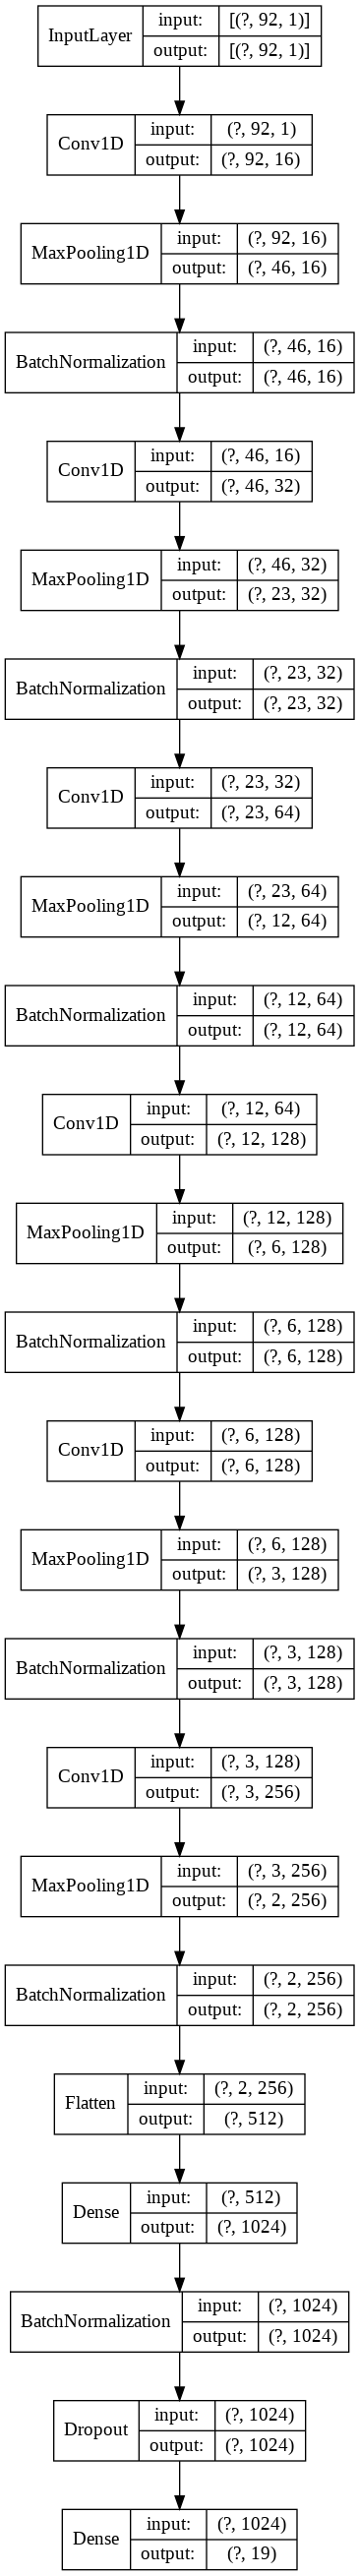

In [37]:
model = Network()
model.summary()
plot_model(model, to_file='model-50000.png', show_shapes=True, show_layer_names=False, expand_nested=True)

In [38]:
print(X.shape)
print(Y.shape)

(50000, 92, 1)
(50000,)


In [39]:
help(MaxPooling1D.__init__)

Help on function __init__ in module tensorflow.python.keras.layers.pooling:

__init__(self, pool_size=2, strides=None, padding='valid', data_format='channels_last', **kwargs)



In [0]:
setEpochNumber     = 20
setBatchSizeNumber = 64

In [41]:
# Setting up the model
model = Network()
model.compile(optimizer=Adam(), # learning_rate=0.005
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Train the model
results = model.fit(x=Xtrain, y=Ytrain,
                    validation_split=0.10,
                    batch_size=setBatchSizeNumber, epochs=setEpochNumber)

Epoch 1/20
633/633 [==============================] - 28s 45ms/step - loss: 3.3349 - accuracy: 0.0759 - val_loss: 3.0568 - val_accuracy: 0.0867
Epoch 2/20
633/633 [==============================] - 28s 44ms/step - loss: 3.0208 - accuracy: 0.1070 - val_loss: 2.9805 - val_accuracy: 0.1089
Epoch 3/20
633/633 [==============================] - 29s 45ms/step - loss: 2.9291 - accuracy: 0.1262 - val_loss: 3.0570 - val_accuracy: 0.1142
Epoch 4/20
633/633 [==============================] - 28s 44ms/step - loss: 2.8507 - accuracy: 0.1494 - val_loss: 2.9734 - val_accuracy: 0.1220
Epoch 5/20
633/633 [==============================] - 28s 44ms/step - loss: 2.7637 - accuracy: 0.1730 - val_loss: 3.0269 - val_accuracy: 0.1267
Epoch 6/20
633/633 [==============================] - 29s 45ms/step - loss: 2.6627 - accuracy: 0.2032 - val_loss: 3.0629 - val_accuracy: 0.1278
Epoch 7/20
633/633 [==============================] - 28s 44ms/step - loss: 2.5576 - accuracy: 0.2341 - val_loss: 3.0833 - val_accuracy:

In [43]:
# Evaluation

print('Training Accuracy: {}'.format(model.evaluate(Xtrain, Ytrain)))
print('Testing Accuracy: {}'.format(model.evaluate(Xtest, Ytest)))

1407/1407 [==============================] - 11s 8ms/step - loss: 0.9560 - accuracy: 0.7809
Training Accuracy: [0.9560131430625916, 0.7809333205223083]
157/157 [==============================] - 1s 8ms/step - loss: 4.8149 - accuracy: 0.1738
Testing Accuracy: [4.814913749694824, 0.1738000065088272]
